In [702]:
import math
import os
import datetime as dt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pmdarima.arima import auto_arima
from scipy.optimize import curve_fit
from statsmodels.tsa.seasonal import STL


import warnings

warnings.filterwarnings('ignore')


# Load Data

In [703]:
data_folder = 'data'

In [704]:
train = pd.read_csv(os.path.join(data_folder, 'train.csv'))
test = pd.read_csv(os.path.join(data_folder, "test.csv"))

In [705]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB


In [706]:
train.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [707]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98550 entries, 0 to 98549
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       98550 non-null  int64 
 1   date     98550 non-null  object
 2   country  98550 non-null  object
 3   store    98550 non-null  object
 4   product  98550 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [708]:
# cast date column

train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

# EDA

### Possible Combinations

In [709]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   id        230130 non-null  int64         
 1   date      230130 non-null  datetime64[ns]
 2   country   230130 non-null  object        
 3   store     230130 non-null  object        
 4   product   230130 non-null  object        
 5   num_sold  221259 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 10.5+ MB


<Axes: >

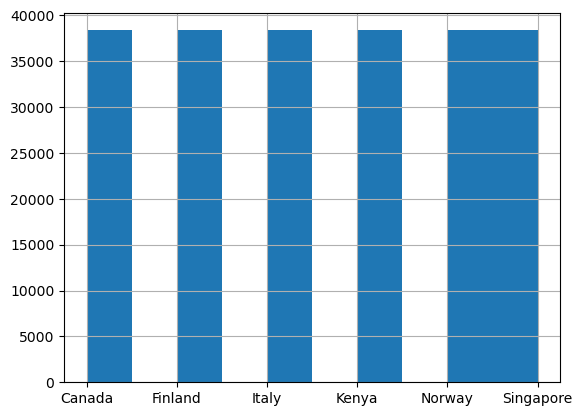

In [710]:
train['country'].hist()

<Axes: >

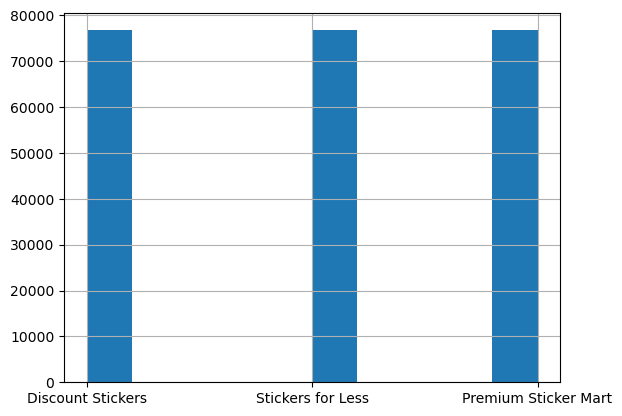

In [711]:
train['store'].hist()

### Null-values

Some of the target values in train set is missing.
Notably, there is **strict cold start** problem for `(Canada, Discount Stickers, Holographic Goose)` and `(Kenya, Discount Stickers, Holographic Goose)`

In [712]:
train.isnull().sum()

id             0
date           0
country        0
store          0
product        0
num_sold    8871
dtype: int64

In [713]:
test.isnull().sum()

id         0
date       0
country    0
store      0
product    0
dtype: int64

In [714]:
missing_value_counts = train[train['num_sold'].isnull()][['country', 'store', 'product']].value_counts()
total_count = train[['country', 'store', 'product']].value_counts().loc[missing_value_counts.index]
pd.DataFrame({'Missing Value':missing_value_counts, 
              'Proportion':(missing_value_counts/total_count).map(lambda x: f'{x:.4%}')})

Missing Value Proportion
country store                product                                     
Canada  Discount Stickers    Holographic Goose            2557  100.0000%
Kenya   Discount Stickers    Holographic Goose            2557  100.0000%
        Stickers for Less    Holographic Goose            1358   53.1091%
Canada  Stickers for Less    Holographic Goose            1308   51.1537%
Kenya   Premium Sticker Mart Holographic Goose             646   25.2640%
Canada  Premium Sticker Mart Holographic Goose             380   14.8612%
Kenya   Discount Stickers    Kerneler                       63    2.4638%
Canada  Discount Stickers    Kerneler                        1    0.0391%
Kenya   Discount Stickers    Kerneler Dark Mode              1    0.0391%

### Time Series Distribution

In [715]:
def plot_grouped_time_series(df, grouped_by = ['store', 'product'], x_axis = 'date', y_axis = 'num_sold', title = 'TITLE'):
    '''
    Group by the columns in groupd_by
    plot a series of y_axis vs. x_axis for each group
    '''
    fig, ax = plt.subplots()

    for group_columns, group in df.groupby(grouped_by):
        group.plot(x=x_axis, y=y_axis, ax=ax, label=group_columns)

    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.title(title)
    plt.legend(title=f'Grouped by: {grouped_by}', bbox_to_anchor=(1.05, 1), loc='upper left')
    #plt.tight_layout()
    plt.show()

def plot_single_series(df, date_col = 'date', quant_col = 'num_sold'):
    # Plotting the time series
    plt.figure(figsize=(10, 6))
    if df.index.name == date_col:
        plt.plot(df.index, df[quant_col], marker='o', color='b', linestyle='-')
    else:
        plt.plot(df[date_col], df[quant_col], marker='o', color='b', linestyle='-')
    plt.title(f'Time Series of {quant_col}')
    plt.xlabel(date_col)
    plt.ylabel(quant_col)
    plt.grid(True)
    plt.show()

def add_stl_plot(fig, res, legend):
    """Add a new STL fit result to an existing plot"""
    axs = fig.get_axes()
    comps = ["observed", "trend", "seasonal", "resid"]
    for ax, comp in zip(axs, comps):
        series = getattr(res, comp)
        if comp == "resid":
            ax.plot(series, marker="o", linestyle="none")
        else:
            ax.plot(series)
            if comp == "observed":
                ax.legend(legend, frameon=False)

##### Group by country and store

1. The scale of `num_sold` vary across countries and stores (e.g. 200-1500 level in Canada v.s. 5-100 level in Kenya)
2. The relative distribution among different products is visually-similar across different `(country, store)` groups

In [716]:
# for country, country_df in train.groupby(['country']):
#     for store, country_store_df in country_df.groupby(['store']):
#         plot_grouped_time_series(country_store_df, title = f'{country} - {store}')

##### Group by product


1. The general seasonality pattern for all products: increase in `num_sold` from mid-year to year-end culminating at spike during holiday seasons, decrease from year-start to mid-year
2. The `num_sold` for the same `product` shows a similar seasonality pattern across different countries
3. Some products show stronger seasonality (Holographic Goose, Kerneler and dark mode) than others

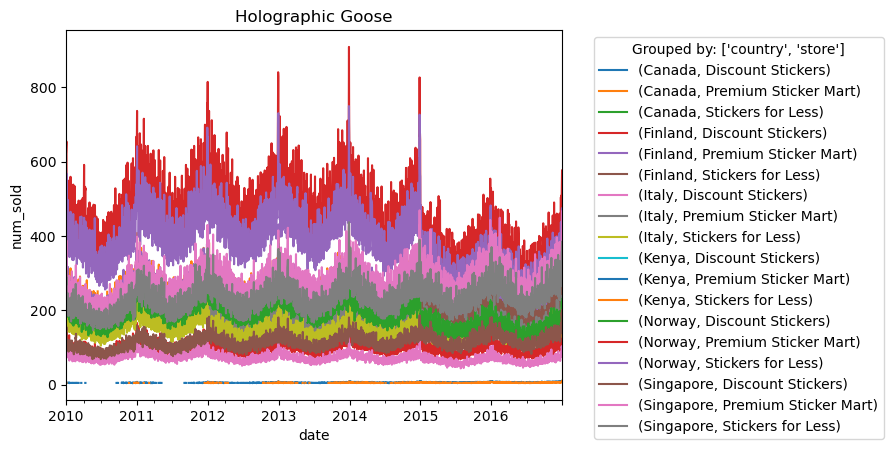

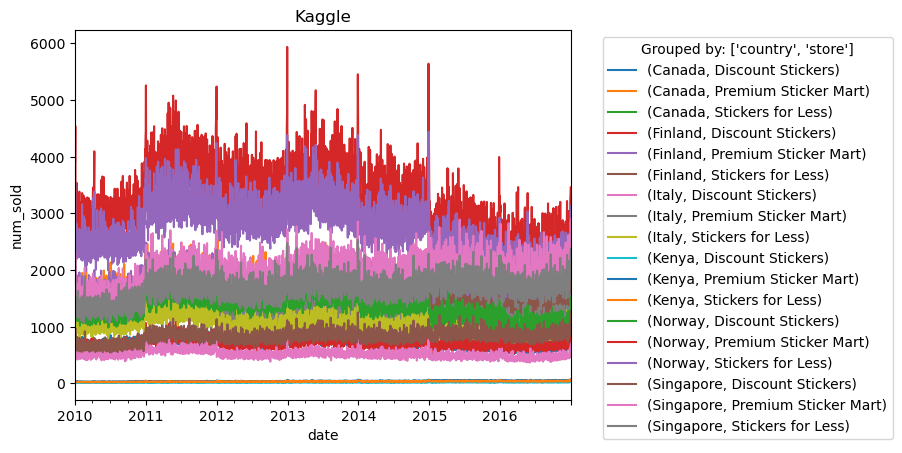

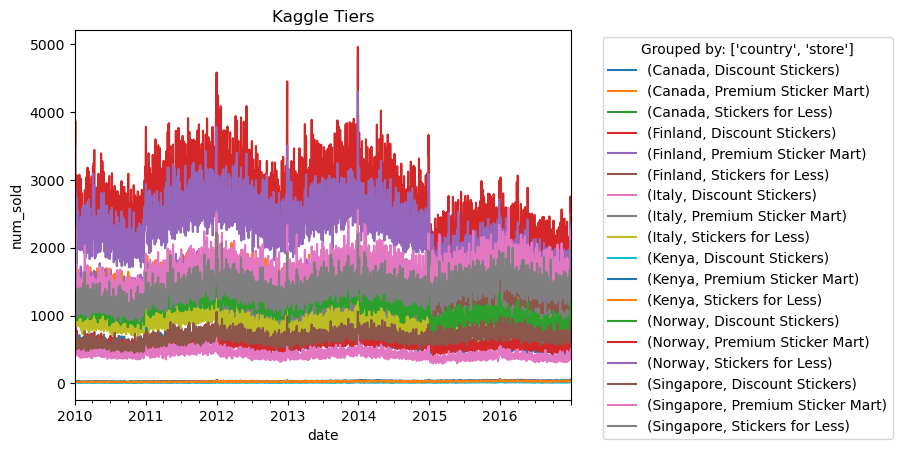

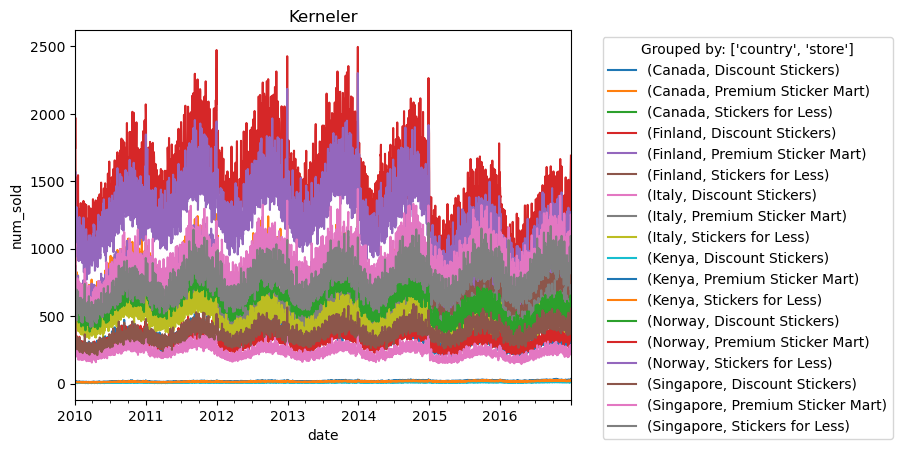

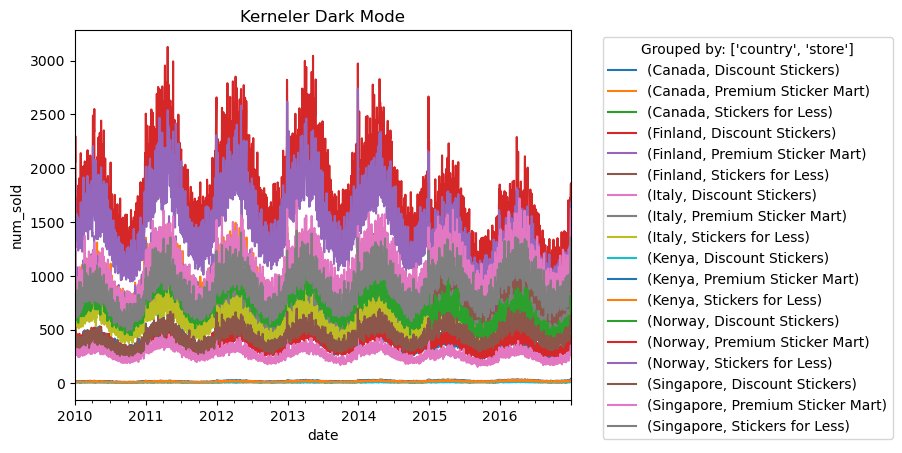

In [717]:
for product, product_df in train.groupby(['product']):
    plot_grouped_time_series(product_df, grouped_by = ['country', 'store'], x_axis = 'date', y_axis = 'num_sold', title = product[0])

Zoom in a bit on Kenya sales. The general pattern still holds.

In [718]:
# for product, product_df in train[train['country'] == 'Kenya'].groupby(['product']):
#     plot_grouped_time_series(product_df, grouped_by = ['country', 'store'], x_axis = 'date', y_axis = 'num_sold', title = product[0])

##### Seasonal-Trend Decomposition (using LOESS)

In [719]:
country = 'Finland'
store = 'Discount Stickers'
df = train[(train['country'] == country) & (train['store'] == store)]
df['product'].unique()

array(['Holographic Goose', 'Kaggle', 'Kaggle Tiers', 'Kerneler',
       'Kerneler Dark Mode'], dtype=object)

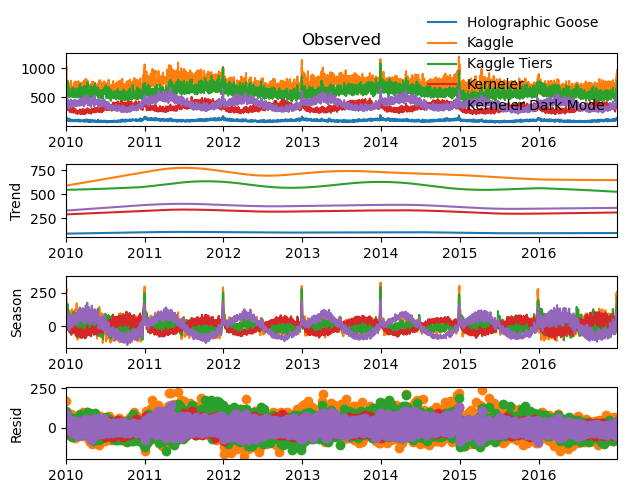

In [720]:
# Some product in different countries/stores

country = 'Finland'
store = 'Discount Stickers'
df = train[(train['country'] == country) & (train['store'] == store)]
fig = None
legend = []
for product in df['product'].unique():
    legend.append(product)
    df_spec = df[df['product'] == product]
    res = STL(df_spec[['date', 'num_sold']].set_index('date'), period = 365).fit()
    if not fig:
        fig = res.plot()
    else:
        # add on existing fig
        add_stl_plot(fig, res, legend = legend)

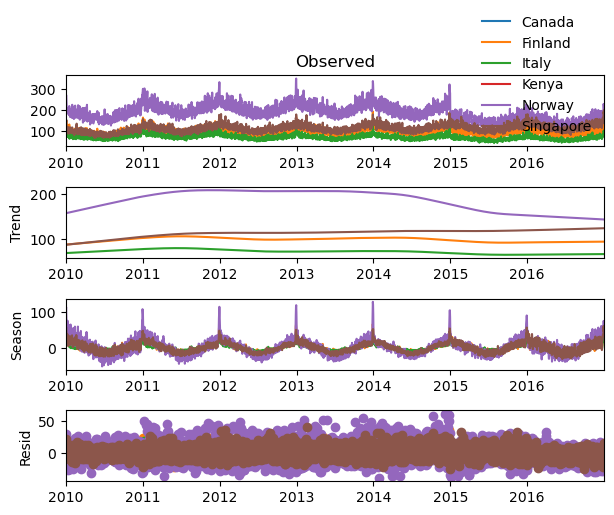

In [721]:
# Does all products in the same country share the same trend/seasonality?

product = 'Holographic Goose'
store = 'Discount Stickers'
df = train[(train['product'] == product) & (train['store'] == store)]
fig = None
legend = []
for country in df['country'].unique():
    legend.append(country)
    df_spec = df[df['country'] == country]
    res = STL(df_spec[['date', 'num_sold']].set_index('date'), period = 365).fit()
    if not fig:
        fig = res.plot()
    else:
        # add on existing fig
        add_stl_plot(fig, res, legend = legend)

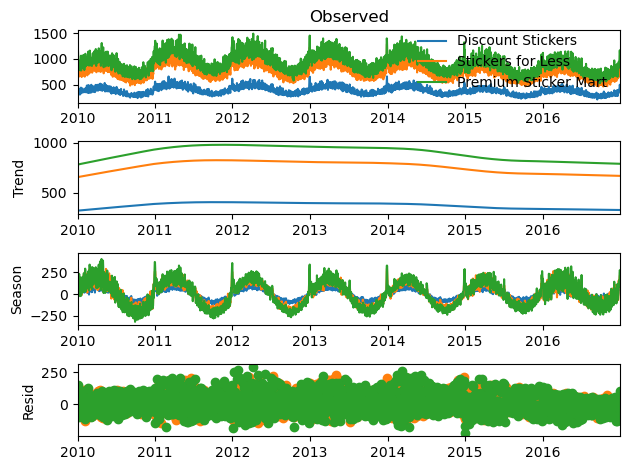

In [722]:

product = 'Kerneler Dark Mode'
country = 'Canada'
df = train[(train['product'] == product) & (train['country'] == country)]
fig = None
legend = []
for store in df['store'].unique():
    legend.append(store)
    df_spec = df[df['store'] == store]
    res = STL(df_spec[['date', 'num_sold']].fillna(method = 'bfill').set_index('date'), period = 365).fit()
    if not fig:
        fig = res.plot()
    else:
        # add on existing fig
        add_stl_plot(fig, res, legend = legend)

# Data Preprocessing

In [723]:
groups_w_missing_value = train[train['num_sold'].isnull()].groupby(['country', 'store', 'product']).count().index
groups_w_missing_value

MultiIndex([('Canada',    'Discount Stickers',  'Holographic Goose'),
            ('Canada',    'Discount Stickers',           'Kerneler'),
            ('Canada', 'Premium Sticker Mart',  'Holographic Goose'),
            ('Canada',    'Stickers for Less',  'Holographic Goose'),
            ( 'Kenya',    'Discount Stickers',  'Holographic Goose'),
            ( 'Kenya',    'Discount Stickers',           'Kerneler'),
            ( 'Kenya',    'Discount Stickers', 'Kerneler Dark Mode'),
            ( 'Kenya', 'Premium Sticker Mart',  'Holographic Goose'),
            ( 'Kenya',    'Stickers for Less',  'Holographic Goose')],
           names=['country', 'store', 'product'])

### Impute Missing Values (Non Cold-start)

In [724]:
def impute(df, missing_column = 'num_sold', method = 'linear',seasonal_period = None, base_interpolate_method = None):
    '''
    
    '''
    df_copy = df.copy()

    # Fill missing values in the time series
    imputed_indices = df[df[missing_column].isnull()].index

    if method == 'linear':
        df_imputed = df_copy[missing_column].interpolate(method = method)
    elif method == 'spline':
        df_imputed = df_copy[missing_column].interpolate(method = method, order = 3)
    elif method == 'STL':
        assert seasonal_period > 0
        assert type(base_interpolate_method) == str and base_interpolate_method in ['linear', 'spline']

        # Interpolate using a base method first to extract the seasonal component
        stl = STL(df_copy[missing_column].interpolate(method = base_interpolate_method, order = 3), period = seasonal_period)
        res = stl.fit()
        seasonal_component = res.seasonal

        # Interpolate the deseasonalized series
        df_deseasonalised = df_copy[missing_column] - seasonal_component
        df_deseasonalised_imputed = df_deseasonalised.interpolate(method=base_interpolate_method, order = 3)

        # Add the seasonal component back
        df_imputed = df_deseasonalised_imputed + seasonal_component

    return imputed_indices, df_imputed

In [725]:
def plot_imputed_series(df, imputed_indices, x = 'date', y = 'num_sold', title = 'Imputation'):
    plt.figure(figsize=[20, 6])

    # plot the complete series
    df.plot(x =x, y = y, style='.-',  label=y)

    # specifically mark out the imputed values
    plt.scatter(df.loc[imputed_indices, x], df.loc[imputed_indices, y], color='red')

    plt.title(title)
    plt.ylabel(x)
    plt.xlabel(y)
    plt.show()

<Figure size 2000x600 with 0 Axes>

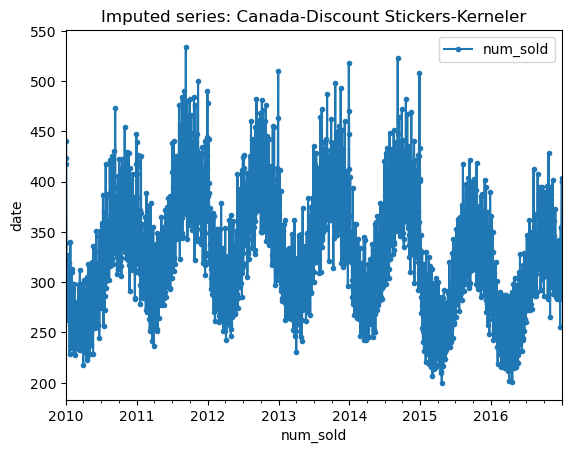

<Figure size 2000x600 with 0 Axes>

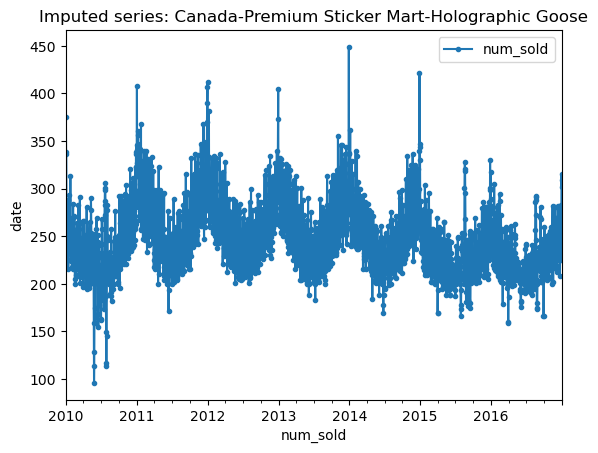

<Figure size 2000x600 with 0 Axes>

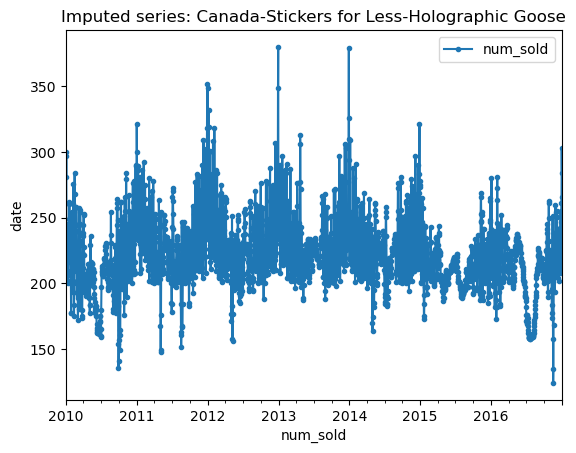

<Figure size 2000x600 with 0 Axes>

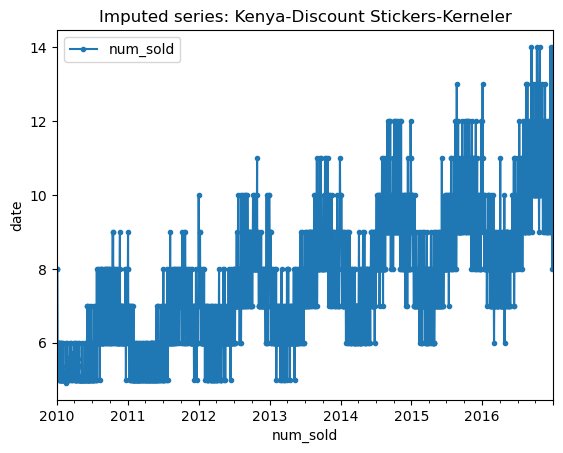

<Figure size 2000x600 with 0 Axes>

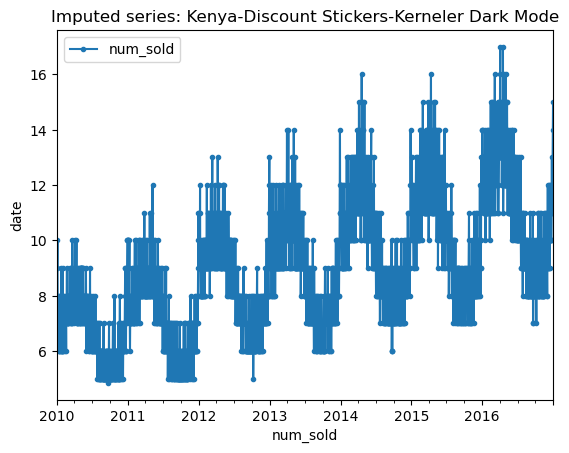

<Figure size 2000x600 with 0 Axes>

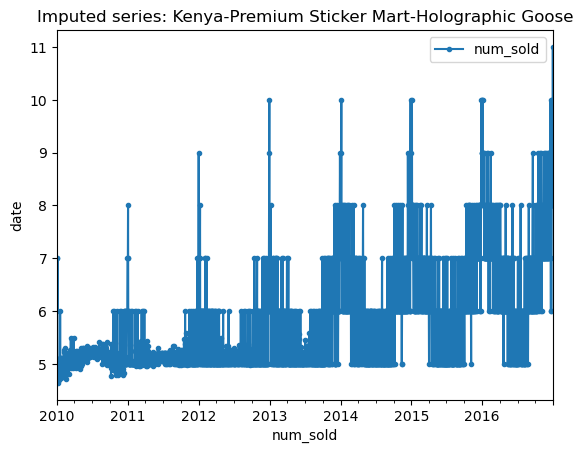

<Figure size 2000x600 with 0 Axes>

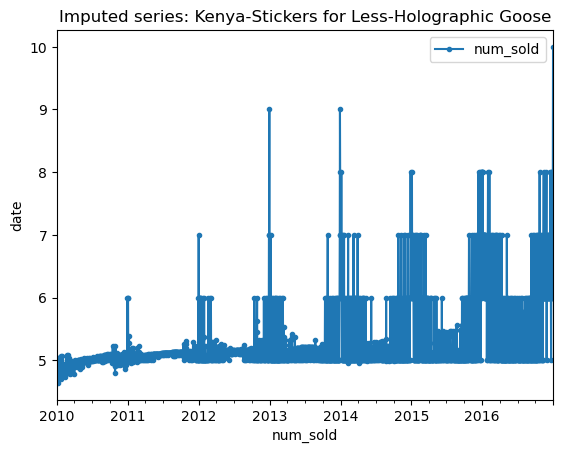

In [726]:
for country, store, product in groups_w_missing_value:
    if (country, store, product) == ('Canada','Discount Stickers','Holographic Goose') \
        or (country, store, product) == ('Kenya','Discount Stickers','Holographic Goose'):
        # cold-start series are not imputed in this phase
        continue

    filtered_df = train[(train['country'] == country) & (train['store'] == store) & (train['product'] == product)]
    imputed_indices, df_imputed = impute(filtered_df, method = 'STL', seasonal_period=365, base_interpolate_method = 'spline')
    train.loc[imputed_indices, 'num_sold'] = df_imputed[imputed_indices]

    plot_imputed_series(train[(train['country'] == country) & (train['store'] == store) & (train['product'] == product)], 
                        imputed_indices, x = 'date', y = 'num_sold', 
                        title = f'Imputed series: {country}-{store}-{product}')

### Impute Missing Values (Cold-Start)

Impute the whole series for `('Canada', 'Discount Stickers','Holographic Goose')` and `('Kenya', 'Discount Stickers','Holographic Goose')`.

An idea is to construct an artificial synthetic time series based on the sales of `Holographic Goose` in the `Discount Stickers` store of other countries.

Specifically, for the sale in Canada, $$Y_{can,ds,holo}^t = Seasonal_{can,ds,holo}^t + Trend_{can,ds,holo}^t + res^t$$

##### Collect Seasonal Pattern 

The synthetic seasonal pattern is defined by $$Seasonal_{can,ds,holo}^t = \frac{\sum_{country \in \{Finland, Italy, Singapore, Norway \}}Seasonal_{country,ds,holo}^t \times \frac{Trend_{can,ds,kerneler}^t}{Trend_{country,ds,kerneler}^t}}{4}$$

Basically, it is the average of the seasonal patterns of `(Discount Stickers, Holographic Goose)` in 4 other countries with complete data, each adjusted by a ratio that accounts for the difference in the scale of sales between countries. The ratio is approximated by the ratio of sales of `Kerneler` because this product has a similar annual pattern and almost complete data across all countries.

In [727]:
record_dict = {}

# extract seasonal patterns for Holographic Goose in Discount Stickers
product = 'Holographic Goose'
store = 'Discount Stickers'
df = train[(train['product'] == product) & (train['store'] == store)]

for country in ['Finland', 'Italy', 'Norway', 'Singapore']:
    df_spec = df[df['country'] == country]
    res = STL(df_spec[['date', 'num_sold']].set_index('date'), period = 365).fit()
    record_dict[f'{product}-{store}-{country}_seasonal'] = res.seasonal

# extract trend patterns for Kerneler in Discount Stickers (this time also for Canada and Kenya)
product = 'Kerneler'
df = train[(train['product'] == product) & (train['store'] == store)]

for country in train['country'].unique():
    df_spec = df[df['country'] == country]
    res = STL(df_spec[['date', 'num_sold']].set_index('date'), period = 365).fit()
    record_dict[f'{product}-{store}-{country}_trend'] = res.trend

In [728]:
record_df = pd.DataFrame(record_dict)
record_df.head()

,Holographic Goose-Discount Stickers-Finland_seasonal,Holographic Goose-Discount Stickers-Italy_seasonal,Holographic Goose-Discount Stickers-Norway_seasonal,Holographic Goose-Discount Stickers-Singapore_seasonal,Kerneler-Discount Stickers-Canada_trend,Kerneler-Discount Stickers-Finland_trend,Kerneler-Discount Stickers-Italy_trend,Kerneler-Discount Stickers-Kenya_trend,Kerneler-Discount Stickers-Norway_trend,Kerneler-Discount Stickers-Singapore_trend
date,,,,,,,,,,
2010-01-01,58.948292,43.363022,102.696866,50.607193,287.341380,288.417061,225.518079,5.749942,515.297155,282.454206
2010-01-02,45.417654,38.078430,113.796536,57.445303,287.461943,288.519596,225.576648,5.750960,515.604981,282.605801
2010-01-03,46.256065,37.691193,79.853420,45.699338,287.582512,288.622160,225.635239,5.751979,515.912826,282.757403
2010-01-04,24.155615,18.011707,63.787864,27.325882,287.703086,288.724753,225.693852,5.752996,516.220689,282.909011
2010-01-05,27.898069,6.139209,45.291332,18.215591,287.823667,288.827375,225.752487,5.754013,516.528571,283.060625


In [729]:
for country in ['Canada', 'Kenya']:
    series = pd.Series(0, index = record_df.index)
    
    for compared_country in ['Finland', 'Italy', 'Norway', 'Singapore']:
        compared_country_series = record_df[f'Holographic Goose-Discount Stickers-{compared_country}_seasonal']
        adjust_ratio = record_df[f'Kerneler-Discount Stickers-{country}_trend'] / record_df[f'Kerneler-Discount Stickers-{compared_country}_trend']
        series +=  compared_country_series * adjust_ratio
    
    series /= 4

    record_df[f'{country}_predicted_seasonal'] = series
    

<Axes: xlabel='date'>

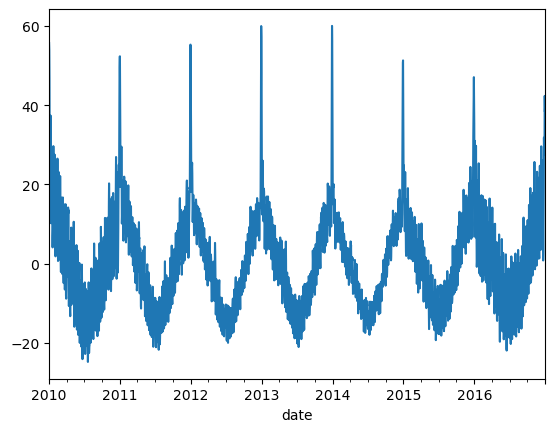

In [730]:
record_df['Canada_predicted_seasonal'].plot()

##### Construct Trend



Observed that the ratio between `(Canada, Discount Stickers, <product>)` and `(Canada, Stickers for Less, <product>)` is similar across all products in all time-stamps. Similar for Kenya.

(<Axes: xlabel='date'>,
 count    2557.000000
 mean        0.495489
 std         0.036396
 min         0.374295
 25%         0.469880
 50%         0.494238
 75%         0.519231
 max         0.645749
 Name: num_sold, dtype: float64)

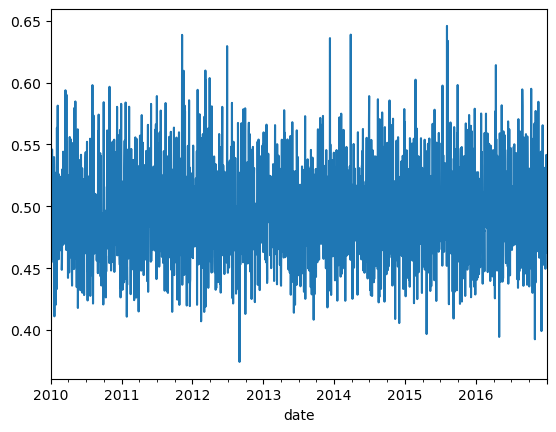

In [281]:
ds = train[(train['product'] == 'Kerneler') & (train['country'] == 'Canada') & (train['store'] == 'Discount Stickers')].set_index('date')['num_sold']
sl = train[(train['product'] == 'Kerneler') & (train['country'] == 'Canada') & (train['store'] == 'Stickers for Less')].set_index('date')['num_sold']

(ds/sl).plot(), (ds/sl).describe()

(<Axes: xlabel='date'>,
 count    2557.000000
 mean        0.482895
 std         0.044902
 min         0.352941
 25%         0.454545
 50%         0.476190
 75%         0.500000
 max         0.714774
 Name: num_sold, dtype: float64)

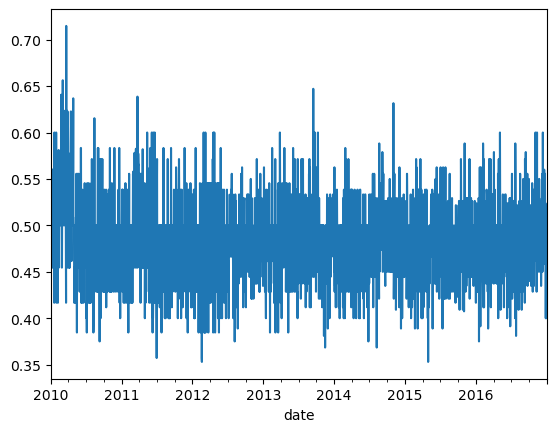

In [282]:
ds = train[(train['product'] == 'Kerneler') & (train['country'] == 'Kenya') & (train['store'] == 'Discount Stickers')].set_index('date')['num_sold']
sl = train[(train['product'] == 'Kerneler') & (train['country'] == 'Kenya') & (train['store'] == 'Stickers for Less')].set_index('date')['num_sold']

(ds/sl).plot(), (ds/sl).describe()

(<Axes: xlabel='date'>,
 count    2557.000000
 mean        0.487476
 std         0.036017
 min         0.378378
 25%         0.461538
 50%         0.486486
 75%         0.513514
 max         0.625000
 Name: num_sold, dtype: float64)

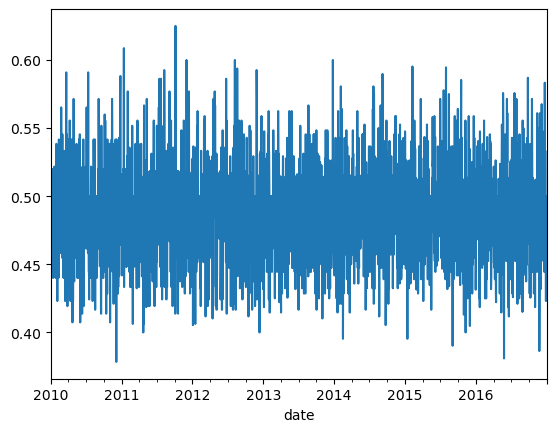

In [283]:
ds = train[(train['product'] == 'Kaggle') & (train['country'] == 'Kenya') & (train['store'] == 'Discount Stickers')].set_index('date')['num_sold']
sl = train[(train['product'] == 'Kaggle') & (train['country'] == 'Kenya') & (train['store'] == 'Stickers for Less')].set_index('date')['num_sold']

(ds/sl).plot(), (ds/sl).describe()

Therefore, to estimate $Trend_{can,ds,holo}$, we scale $Trend_{can,sl,holo}$ (sl means "Stickers for Less") by the factor, $avg(\frac{Y_{can,ds,kn}}{Y_{can,sl,kn}})$

$$Trend_{can,ds,holo}^t = Trend_{can,sl,holo}^t\times avg(\frac{Y_{can,ds,kn}}{Y_{can,sl,kn}})$$

In [284]:
record_df.columns

Index(['Holographic Goose-Discount Stickers-Finland_seasonal',
       'Holographic Goose-Discount Stickers-Italy_seasonal',
       'Holographic Goose-Discount Stickers-Norway_seasonal',
       'Holographic Goose-Discount Stickers-Singapore_seasonal',
       'Kerneler-Discount Stickers-Canada_trend',
       'Kerneler-Discount Stickers-Finland_trend',
       'Kerneler-Discount Stickers-Italy_trend',
       'Kerneler-Discount Stickers-Kenya_trend',
       'Kerneler-Discount Stickers-Norway_trend',
       'Kerneler-Discount Stickers-Singapore_trend',
       'Canada_predicted_seasonal', 'Kenya_predicted_seasonal'],
      dtype='object')

In [285]:
record_df['Kerneler-Stickers for Less-Canada'] = train[(train['country'] == 'Canada') \
                                                             & (train['product'] == 'Kerneler') \
                                                                & (train['store'] == 'Stickers for Less')]['num_sold']
record_df['Kerneler-Stickers for Less-Kenya'] = train[(train['country'] == 'Kenya') \
                                                             & (train['product'] == 'Kerneler') \
                                                                & (train['store'] == 'Stickers for Less')]['num_sold']

ds_can = train[(train['product'] == 'Kerneler') & (train['country'] == 'Canada') & (train['store'] == 'Discount Stickers')].set_index('date')['num_sold']
sl_can = train[(train['product'] == 'Kerneler') & (train['country'] == 'Canada') & (train['store'] == 'Stickers for Less')].set_index('date')['num_sold']
ratio_can = (ds_can/sl_can).mean()

ds_ken = train[(train['product'] == 'Kerneler') & (train['country'] == 'Kenya') & (train['store'] == 'Discount Stickers')].set_index('date')['num_sold']
sl_ken = train[(train['product'] == 'Kerneler') & (train['country'] == 'Kenya') & (train['store'] == 'Stickers for Less')].set_index('date')['num_sold']
ratio_ken = (ds_ken/sl_ken).mean()


In [286]:
# extract trend patterns for Holographic Goose in Stickers for Less (for Canada and Kenya)
product = 'Holographic Goose'
store = 'Stickers for Less'
df = train[(train['product'] == product) & (train['store'] == store)]

for country in ['Canada', 'Kenya']:
    df_spec = df[df['country'] == country]
    res = STL(df_spec[['date', 'num_sold']].set_index('date'), period = 365).fit()
    record_df[f'Holographic Goose-Stickers for Less-{country}_trend'] = res.trend

In [287]:
record_df['Holographic Goose-Stickers for Less-Canada_trend']

date
2010-01-01    201.407792
2010-01-02    201.467926
2010-01-03    201.528045
2010-01-04    201.588148
2010-01-05    201.648235
                 ...    
2016-12-27    206.892357
2016-12-28    206.877930
2016-12-29    206.863509
2016-12-30    206.849095
2016-12-31    206.834688
Name: Holographic Goose-Stickers for Less-Canada_trend, Length: 2557, dtype: float64

In [288]:
record_df['Canada_predicted_trend'] = record_df['Holographic Goose-Stickers for Less-Canada_trend'] * ratio_can
record_df['Kenya_predicted_trend'] = record_df['Holographic Goose-Stickers for Less-Kenya_trend'] * ratio_ken

##### Construct Residuals

For both Canada and Kenya, residuals will be a $\mathcal{N}(0, \sigma)$ white-noise series. Observe that for `Holographic Goose`, the variance of the sale at `Discount Stickers` is roughly $\frac{1}{2}$ of that in `Stickers for Less`.

In [289]:
product = 'Holographic Goose'
df = train[(train['product'] == product)]
for country in df['country'].unique():
    for store in df['store'].unique():
        df_spec = df[(df['product'] == product)&(df['country'] == country)&(df['store'] == store)]
        if df_spec['num_sold'].isna().any():
            continue
        res = STL(df_spec[['date', 'num_sold']].set_index('date'), period = 365).fit()
        print(country, store)
        print(f'mean = {(res.resid).mean()}, std = {(res.resid).std()}')

Canada Stickers for Less
mean = 0.24972563929764213, std = 14.769332518813172
Canada Premium Sticker Mart
mean = 0.36236900991059956, std = 17.625970368828995
Finland Discount Stickers
mean = 0.13035441264319672, std = 7.645395379827864
Finland Stickers for Less
mean = 0.22752080699090932, std = 15.14412445040475
Finland Premium Sticker Mart
mean = 0.2748359720378021, std = 18.089848035597814
Italy Discount Stickers
mean = 0.0748599892039271, std = 5.318533540254789
Italy Stickers for Less
mean = 0.14108602200339976, std = 10.55252761399938
Italy Premium Sticker Mart
mean = 0.1534099575945014, std = 13.035041499873874
Kenya Stickers for Less
mean = -0.0016720171722028976, std = 0.2723958578116085
Kenya Premium Sticker Mart
mean = -0.004922953030099859, std = 0.40987764625097955
Norway Discount Stickers
mean = 0.4550560582627726, std = 14.94362830757158
Norway Stickers for Less
mean = 0.8890728964989354, std = 29.77295692575437
Norway Premium Sticker Mart
mean = 1.0987647682603814, std 

In [291]:
record_df['Holographic Goose-Discount Stickers-Canada_resid'] = np.random.normal(0, 14.769332518813172 * 0.5, size = len(record_df))
record_df['Holographic Goose-Discount Stickers-Kenya_resid'] = np.random.normal(0, 0.2723958578116085 * 0.5, size = len(record_df))

#### Fill in the synthetic time-series

In [293]:
can_predicted = record_df['Canada_predicted_trend'] + record_df['Canada_predicted_seasonal'] + record_df['Holographic Goose-Discount Stickers-Canada_resid']
ken_predicted = record_df['Kenya_predicted_trend'] + record_df['Kenya_predicted_seasonal'] + record_df['Holographic Goose-Discount Stickers-Kenya_resid']

can_predicted = can_predicted.rename('Canada').reset_index()
ken_predicted = ken_predicted.rename('Kenya').reset_index()

In [294]:
# Create a mask to identify rows in train that match the specified conditions
can_mask = (train['country'] == 'Canada') & (train['store'] == 'Discount Stickers') & (train['product'] == 'Holographic Goose')
ken_mask = (train['country'] == 'Kenya') & (train['store'] == 'Discount Stickers') & (train['product'] == 'Holographic Goose')

# Update the "num_sold" column in train only for rows that match the conditions
train.loc[can_mask, 'num_sold'] = can_predicted['Canada'].values
train.loc[ken_mask, 'num_sold'] = ken_predicted['Kenya'].values

In [295]:
train.isnull().sum()

id          0
date        0
country     0
store       0
product     0
num_sold    0
dtype: int64

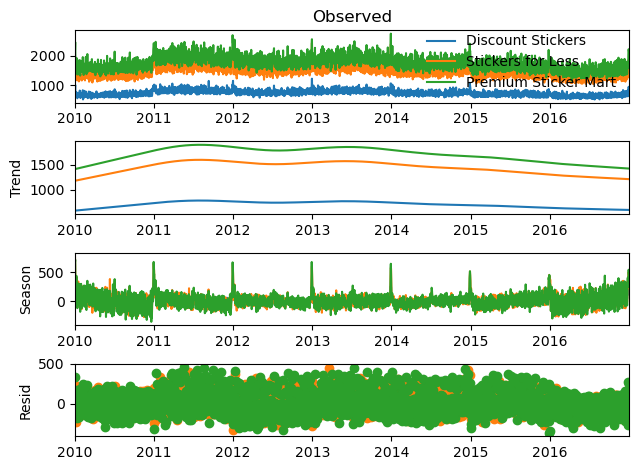

In [697]:
product = 'Kaggle'
country = 'Canada'
df = train[(train['product'] == product) & (train['country'] == country)]
fig = None
legend = []
for store in df['store'].unique():
    legend.append(store)
    df_spec = df[df['store'] == store]
    res = STL(df_spec[['date', 'num_sold']].fillna(method = 'bfill').set_index('date'), period = 365).fit()
    if not fig:
        fig = res.plot()
    else:
        # add on existing fig
        add_stl_plot(fig, res, legend = legend)

C:\Users\xiaoyicong\AppData\Local\Temp\ipykernel_17508\402987308.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  res = STL(df_spec[['date', 'num_sold']].fillna(method = 'bfill').set_index('date'), period = 365).fit()
C:\Users\xiaoyicong\AppData\Local\Temp\ipykernel_17508\402987308.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  res = STL(df_spec[['date', 'num_sold']].fillna(method = 'bfill').set_index('date'), period = 365).fit()
C:\Users\xiaoyicong\AppData\Local\Temp\ipykernel_17508\402987308.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  res = STL(df_spec[['date', 'num_sold']].fillna(method = 'bfill').set_index('date'), period = 365).fit()


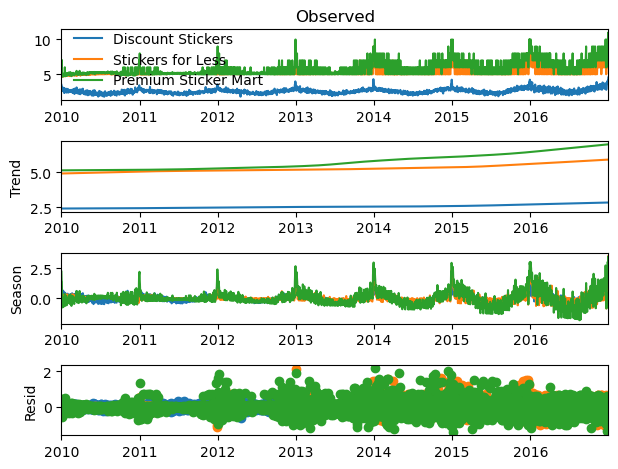

In [297]:
product = 'Holographic Goose'
country = 'Kenya'
df = train[(train['product'] == product) & (train['country'] == country)]
fig = None
legend = []
for store in df['store'].unique():
    legend.append(store)
    df_spec = df[df['store'] == store]
    res = STL(df_spec[['date', 'num_sold']].fillna(method = 'bfill').set_index('date'), period = 365).fit()
    if not fig:
        fig = res.plot()
    else:
        # add on existing fig
        add_stl_plot(fig, res, legend = legend)

# Modelling

### Model Design

To deal with long and seasonal time series, I use a mixture of Polynomial Regression, Fourier Series, and ARIMA to capture the trend, seasonality and residual errors respectively. The model is defined as:

$$Y_t = a + \sum_{i = 1}^I a_i x^i + \sum_{k=1}^K \alpha_k sin(\frac{2\pi k t}{T}) + \beta_k cos(\frac{2\pi k t}{T}) + \varepsilon_t$$ 

In [683]:

class fourier_arima():

    def __init__(self, 
                 data: pd.Series, 
                 polynomial_order: int, 
                 fourier_order: int, 
                 fourier_period: int):
        
        self.data = data
        self.polynomial_order = polynomial_order
        self.fourier_order = fourier_order
        self.fourier_period = fourier_period

        # keep an ordinal (integer) version of data indices
        # this is needed for Fourier regression
        if isinstance(self.data.index , pd.DatetimeIndex):
            self.date_idx_ord = self.data.index.map(dt.datetime.toordinal)
        else:
            self.date_idx_ord = self.data.index
        
        self.first_ord = self.date_idx_ord[0]

        self.trend_seas_params = None
        self.param_covariance = None
        self.res_model = None
        self.fitted_values = None

    def __str__(self):
        '''Print the structure and fitted result (if any) of the model'''
        
        struct_str = f'Sturcture: Polynomial order: {self.polynomial_order}, Fourier order :{self.fourier_order}, Fourier period :{self.fourier_period}\n'
        
        trend_seas_str = ''
        if self.trend_seas_params is not None:
            std_dev = np.sqrt(np.diag(self.param_covariance))

            for poly_order in range(self.polynomial_order + 1):
                value = self.trend_seas_params[poly_order].round(4)
                std = std_dev[poly_order]
                trend_seas_str += f'Polynomial order {poly_order}: {value}, CI: [{value - 1.96 * std}, {value + 1.96 * std}]\n'
            
            for fourier_param_idx in range(1, 2 * self.fourier_order, 2): 
                fourier_order = math.ceil(fourier_param_idx / 2)
                a, b = self.trend_seas_params[fourier_param_idx + self.polynomial_order], self.trend_seas_params[fourier_param_idx + self.polynomial_order + 1]
                std_a, std_b = std_dev[fourier_param_idx + self.polynomial_order], std_dev[fourier_param_idx + self.polynomial_order + 1]
                trend_seas_str += f'Fourier order {fourier_order}: {a} (cos) CI: [{a - 1.96 * std_a}, {a + 1.96 * std_a}] |||| {b} (sin) CI: [{b - 1.96 * std_b}, {b + 1.96 * std_b}]\n'

        res_str = "Residual: " + str(self.res_model.params())
        return struct_str + trend_seas_str + res_str
    
    def fit_trend_seas(self, x, *params):
            omega = 2*np.pi/self.fourier_period
            
            y_pred = pd.Series([0]*len(x), index = x)
            
            # account for Trend
            # a + b*x + c*(x^2) + ... + e(x^polynomial_order)
            for poly_order in range(self.polynomial_order + 1):
                y_pred += params[poly_order] * (x ** poly_order)
            
            # account for Seasonality
            for fourier_param_idx in range(1, 2 * self.fourier_order, 2):
                fourier_order = math.ceil(fourier_param_idx / 2)
                y_pred += params[fourier_param_idx + self.polynomial_order] * np.cos(omega*fourier_order*x)\
                    + params[fourier_param_idx + self.polynomial_order + 1] * np.sin(omega*fourier_order*x)
            
            
            return y_pred
    
    def fit(self):
        
        # fit trend and seasonaly using Polynomial and Fourier regression
        self.trend_seas_params, self.param_covariance = curve_fit(self.fit_trend_seas, 
                                    xdata = self.date_idx_ord-self.first_ord, 
                                    ydata = self.data['num_sold'], 
                                    method='lm', 
                                    p0 = np.ones(self.polynomial_order + 1 + 2 * self.fourier_order))

        self.trend_seas_fitted_values = self.fit_trend_seas(self.date_idx_ord-self.first_ord, *self.trend_seas_params)

        if not isinstance(self.trend_seas_fitted_values.index, pd.DatetimeIndex):  # change the index back to DatetimeIndex
            self.trend_seas_fitted_values.index += self.first_ord
            self.trend_seas_fitted_values.index = self.trend_seas_fitted_values.index.map(dt.datetime.fromordinal)
        
        # fit residuals using ARIMA
        residual_values = self.data['num_sold'] - self.trend_seas_fitted_values
        self.res_model = auto_arima(residual_values, max_p = 30, max_d = 2, max_q = 30, seasonal = False)
        self.residual_fitted_values = self.res_model.predict_in_sample()
        
        # TOTAL FITTED VALUES
        self.fitted_values = (self.trend_seas_fitted_values + self.residual_fitted_values).rename("num_sold")
    
    def forecast(self, steps: int) -> pd.Series:
        # Extend #steps indices from the end of fitted data index
        ordinal_start = self.data.index.map(dt.datetime.toordinal)[-1] + 1
        ordinal_end = self.data.index.map(dt.datetime.toordinal)[-1] + steps
        oos_ordinal_idx = pd.Index(list(range(ordinal_start, ordinal_end + 1)))#.map(dt.datetime.fromordinal)
    
        # Forecast trend and seasonal components
        trend_seas_forecast = self.fit_trend_seas(oos_ordinal_idx-self.first_ord, *self.trend_seas_params)
        if not isinstance(trend_seas_forecast.index, pd.DatetimeIndex):  # change the index back to DatetimeIndex
            trend_seas_forecast.index += self.first_ord
            trend_seas_forecast.index = trend_seas_forecast.index.map(dt.datetime.fromordinal)

        # Forecaset residual
        residual_forecast = self.res_model.predict(n_periods = steps)
        
        return (trend_seas_forecast + residual_forecast).rename('num_sold')

        

def RSS(y, y_pred):
    return np.sqrt( (y - y_pred)**2 ).sum()

def MAPE(y, y_pred):
    return np.abs((y_pred - y)/y).mean()


### Proof of Concept

A single example.

In [686]:
country = 'Canada'
product = 'Kerneler'
store = 'Discount Stickers'

df = train[(train['product'] == product) & (train['country'] == country) & (train['store'] == store)]

series = df[['date', 'num_sold']].set_index('date')


In [687]:
train_series = series.loc['2010-01-01':'2015-12-31']
val_series = series.loc['2016-01-01':]

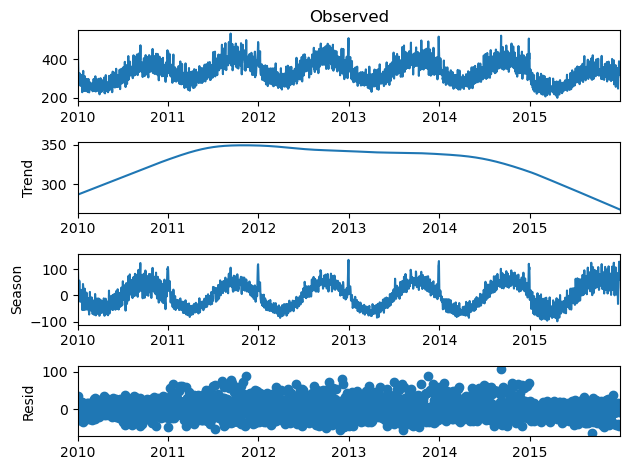

In [688]:
STL(train_series, period = 365).fit().plot();

Sturcture: Polynomial order: 3, Fourier order :10, Fourier period :365
Polynomial order 0: 297.924, CI: [292.01297179767374, 303.8350282023262]
Polynomial order 1: 0.1146, CI: [0.0911811083084186, 0.13801889169158138]
Polynomial order 2: -0.0001, CI: [-0.000124854213210025, -7.514578678997501e-05]
Polynomial order 3: 0.0, CI: [-7.466059605596374e-09, 7.466059605596374e-09]
Fourier order 1: 2.954255558065298 (cos) CI: [0.9177268502730107, 4.9907842658575845] |||| -57.20574988166696 (sin) CI: [-59.300216668711705, -55.111283094622216]
Fourier order 2: 4.073329131309764 (cos) CI: [2.037536984918044, 6.109121277701485] |||| -1.3351932026837379 (sin) CI: [-3.3871123434829418, 0.7167259381154658]
Fourier order 3: 3.9804985569106455 (cos) CI: [1.9447532924731266, 6.016243821348164] |||| -1.5643587884512258 (sin) CI: [-3.607862120745132, 0.4791445438426807]
Fourier order 4: 3.8128514638862603 (cos) CI: [1.7771160025184876, 5.848586925254033] |||| -0.74850920107373 (sin) CI: [-2.789025736168968

<Axes: xlabel='date'>

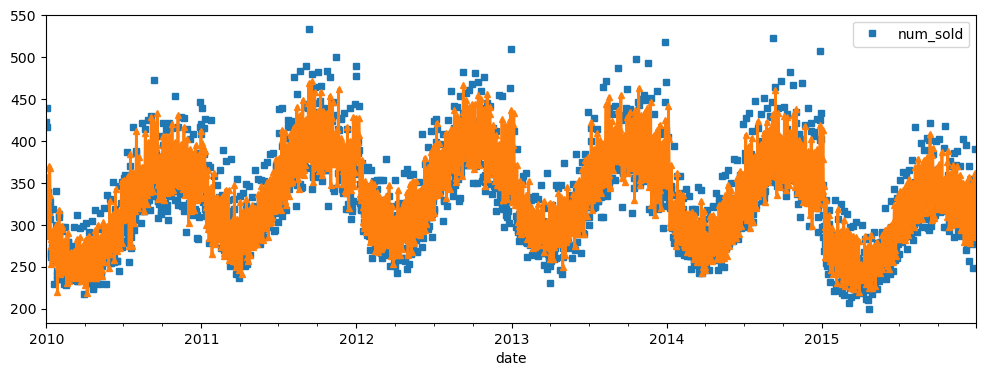

In [689]:
# Fitting

model = fourier_arima(data = train_series, polynomial_order=3, fourier_order=10, fourier_period=365)
model.fit()

print(model)

assert len(train_series) == len(model.fitted_values)
print(f'MAPE: {MAPE(train_series.values.reshape(-1), model.fitted_values.values.reshape(-1)).round(5)}')

train_series.plot(figsize=(12,4), style='s', markersize=4, linewidth=2 )
model.fitted_values.plot(figsize=(12,4), style='^-' , markersize=4, linewidth=2 )

In [690]:
# Out-of-sample prediction

forecast = model.forecast(steps = len(val_series))
MAPE(val_series.values.reshape(-1), forecast.values.reshape(-1))

0.1017024493302233

### Training and Prediction

In [691]:
test

,id,date,country,store,product
0,230130,2017-01-01,Canada,Discount Stickers,Holographic Goose
1,230131,2017-01-01,Canada,Discount Stickers,Kaggle
2,230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers
3,230133,2017-01-01,Canada,Discount Stickers,Kerneler
4,230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode
...,...,...,...,...,...
98545,328675,2019-12-31,Singapore,Premium Sticker Mart,Holographic Goose
98546,328676,2019-12-31,Singapore,Premium Sticker Mart,Kaggle
98547,328677,2019-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers
98548,328678,2019-12-31,Singapore,Premium Sticker Mart,Kerneler


In [ ]:
test['num_sold'] = pd.Series([0] * len(test))

for country in test['country'].unique():
    for store in test['store'].unique():
        for product in test['product'].unique():
            train_df = train[(train['product'] == product) & (train['country'] == country) & (train['store'] == store)]
            train_series = train_df[['date', 'num_sold']].set_index('date')

            # Fitting
            model = fourier_arima(data = train_series, polynomial_order=3, fourier_order=10, fourier_period=365)
            model.fit()

            assert len(train_series) == len(model.fitted_values)
            print(f'{country}-{store}-{product} MAPE: {MAPE(train_series.values.reshape(-1), model.fitted_values.values.reshape(-1)).round(5)}')

            # train_series.plot(figsize=(12,4), style='s', markersize=4, linewidth=2 )
            # model.fitted_values.plot(figsize=(12,4), style='^-' , markersize=4, linewidth=2 )

            
            # Forecasting
            test_df = test[(test['product'] == product) & (test['country'] == country) & (test['store'] == store)]
            forecast = model.forecast(steps = len(test_df)).rename('num_sold').reset_index()
            mask = (test['country'] == country) & (test['store'] == store) & (test['product'] == product)
            test.loc[mask, 'num_sold'] = forecast['num_sold'].values
        

In [ ]:
res = test[['id', 'num_sold']]

In [ ]:
res.to_csv('submission.csv', index = False)